## Start of our student loan balance analysis

In [10]:
# Install packages
install.packages(c('janitor','car'))

Warning message:
"package 'car' is in use and will not be installed"
Installing package into 'C:/Users/CJ/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'janitor' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\CJ\AppData\Local\Temp\RtmpuuoB81\downloaded_packages


In [127]:
library(dplyr)
library(janitor)
library(purrr)
library(glue)
library(stringr)
library(readxl)
library(glmnet)
library(car)
library(dplyr)
library(janitor)
library(purrr)
library(glue)
library(stringr)
library(readxl)
library(broom)     
library(car)
library(lmtest)
library(gvlma)
library(nortest)
library(olsrr)
library(ggplot2)
library(patchwork)


## Data Cleaning

In [36]:
load_and_combine_data <- function(directory_path) {
  
  file_pattern <- glue(".*-Data\\.csv$")
  
  file_paths <- list.files(path = directory_path, pattern = file_pattern, full.names = TRUE)
  
  list_of_dfs <- map(file_paths, function(path) { 
    
    year_match_result <- regmatches(path, regexpr("Y(\\d{4})\\.*", path))
    
    year_extracted <- sub("Y(\\d{4})\\.*", "\\1", year_match_result)
    
    read.csv(path, skip = 1, na.strings = c("N", "-", "(X)", "null")) %>% 
      clean_names() %>%
      mutate(year = as.numeric(year_extracted)) %>%
      mutate(state = str_trim(str_extract(geographic_area_name, ",\\s*([^,]+)$"), side = "left"),
             state = str_replace(state, "^,\\s*", "")) %>%
      select(-contains(c("margin_of_error", "ratio", "unit", "percent", "x", "geograph")))
      }
    )
  
  common_columns <- names(list_of_dfs[[1]])
  
  for (i in 2:length(list_of_dfs)) {
    common_columns <- intersect(common_columns, names(list_of_dfs[[i]]))
  }
  
  list_of_dfs_common_cols <- map(list_of_dfs, ~ .x %>% select(all_of(common_columns)))
  
  for (col_name in common_columns) {
    first_col_type <- class(list_of_dfs_common_cols[[1]][[col_name]])
    
    if (first_col_type %in% c("numeric", "integer")) {
      list_of_dfs_common_cols <- map(list_of_dfs_common_cols, function(df) {
        df[[col_name]] <- as.numeric(df[[col_name]])
        df
      })
    } else if (first_col_type == "factor") {
      list_of_dfs_common_cols <- map(list_of_dfs_common_cols, function(df) {
        df[[col_name]] <- as.character(df[[col_name]])
        df
      })
    }
  }
  
  yearly_data <- bind_rows(list_of_dfs_common_cols)
  
  yearly_data
}

load_and_combine_borrower_data <- function(filepath, sheet_numbers, years) {

  combined_borrower_data <- map2_df(sheet_numbers, years, function(sheet, year) {
    read_excel(filepath, sheet = sheet, skip = 7) %>%
    clean_names() %>%
    mutate(year = year)
  })
  
  final_borrower_data <- combined_borrower_data %>%
    select(state, year, total_borrowers, total_balance_billions)
  
  final_borrower_data
}

dem_data <- load_and_combine_data("../data/dem") 
economic_data <- load_and_combine_data("../data/economic")
mean_income_data <- load_and_combine_data("../data/mean_income")
social_char_data <- load_and_combine_data("../data/social_char") 
borrower_data <-load_and_combine_borrower_data("../data/Student-loan-update-2025-Mangrum.xlsx", 11:15, 2019:2023)

dim(dem_data)

dem_data_cleaned <- dem_data %>%
  rename(total_population = estimate_race_total_population,
         race_white = estimate_race_total_population_one_race_white,
         race_black = estimate_race_total_population_one_race_black_or_african_american,
         race_asian = estimate_race_total_population_one_race_asian,
         race_native = estimate_race_total_population_one_race_american_indian_and_alaska_native,
         race_pacific_islander = estimate_race_total_population_one_race_native_hawaiian_and_other_pacific_islander,
         race_other = estimate_race_total_population_one_race_some_other_race,
         race_two_or_more = estimate_race_total_population_two_or_more_races,
         hispanic_or_latino = estimate_hispanic_or_latino_and_race_total_population_hispanic_or_latino_of_any_race,
         total_18_or_over_population = estimate_citizen_voting_age_population_citizen_18_and_over_population,
         population_18_or_over_male = estimate_citizen_voting_age_population_citizen_18_and_over_population_male,
         population_18_or_over_female = estimate_citizen_voting_age_population_citizen_18_and_over_population_female) %>%
  select(-contains("estimate")) %>%
  group_by(state, year) %>%
  summarise(across(everything(), ~sum(., na.rm=TRUE))) %>%
  ungroup() %>%
  mutate(across(race_two_or_more:hispanic_or_latino, ~./total_population),
         across(population_18_or_over_male:population_18_or_over_female, ~./total_18_or_over_population))

economic_data_cleaned <- economic_data %>%
  rename(employment_total = estimate_employment_status_population_16_years_and_over,
         employement_total_employed = estimate_employment_status_population_16_years_and_over_in_labor_force,
         employment_total_unemployed = estimate_employment_status_population_16_years_and_over_not_in_labor_force) %>%
  select(-contains("estimate"))  %>%
  group_by(state, year) %>%
  summarise(across(everything(), ~sum(., na.rm=TRUE))) %>%
  ungroup() %>%
  mutate(across(employement_total_employed:employment_total_unemployed, ~./employment_total)) %>%
  select(-employment_total)

mean_income_data_cleaned <- mean_income_data %>%
  group_by(state, year) %>%
  summarise(mean_household_income_dollars = mean(estimate_mean_income_dollars_household_income_all_households, na.rm=TRUE)) %>%
  ungroup()

social_char_data_cleaned <- social_char_data %>%
  rename(average_household_size = estimate_households_by_type_total_households_average_household_size,
         total_veteran_eligible = estimate_veteran_status_civilian_population_18_years_and_over,
         total_veteran = estimate_veteran_status_civilian_population_18_years_and_over_civilian_veterans,
         total_population_degree = estimate_educational_attainment_population_25_years_and_over,
         total_population_bachelors_degree = estimate_educational_attainment_population_25_years_and_over_bachelor_s_degree_or_higher,
         total_foreign_born_pop = estimate_u_s_citizenship_status_foreign_born_population,
         total_households = estimate_households_by_type_total_households,
         total_household_w_internet = estimate_computers_and_internet_use_total_households_with_a_broadband_internet_subscription) %>%
  select(-contains("estimate")) %>%
  group_by(state, year) %>%
  summarise(across(-average_household_size, ~sum(., na.rm=TRUE)), 
            average_household_size = mean(average_household_size, na.rm=TRUE)) %>%
  ungroup() %>%
  mutate(total_veteran = total_veteran/total_veteran_eligible, 
         total_population_bachelors_degree = total_population_bachelors_degree/total_population_degree,
         total_household_w_internet = total_household_w_internet/total_households) %>%
  select(-c(total_veteran_eligible, total_population_degree, total_households))


combined_data <- dem_data_cleaned %>%
  left_join(economic_data_cleaned, by = c("state", "year")) %>%
  left_join(mean_income_data_cleaned, by = c("state", "year")) %>%
  left_join(social_char_data_cleaned, by = c("state", "year")) %>%
  left_join(borrower_data, by = c("state", "year")) %>%
  relocate(state, year) %>%
  filter(!state == "Puerto Rico", !state == "District of Columbia") %>%
  mutate(total_foreign_born_pop = total_foreign_born_pop/total_population,
         total_borrowers = total_borrowers/total_18_or_over_population) %>%
  select(-c(total_population, total_18_or_over_population))

write.csv(combined_data, "../data/combined_clean_data.csv", row.names = FALSE)
cat("Save successful! Check `data/`")

[1] 16106    50

`summarise()` has grouped output by 'state'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'state'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'state'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'state'. You can override using the
`.groups` argument.


Save successful! Check `data/`

## Exploratory Data Analysis

In [147]:
student_debt_data <- read.csv("../data/combined_clean_data.csv")
head(student_debt_data)

,state,year,race_two_or_more,race_white,race_black,race_native,race_asian,race_pacific_islander,race_other,hispanic_or_latino,⋯,employement_total_employed,employment_total_unemployed,mean_household_income_dollars,total_population_bachelors_degree,total_veteran,total_foreign_born_pop,total_household_w_internet,average_household_size,total_borrowers,total_balance_billions
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Alabama,2019,0.01891207,0.6809017,0.26640308,0.005242758,0.01359036,0.0004589592,0.01449105,0.04278411,⋯,0.5740216,0.4259784,59561.31,0.2546833,0.08766780,0.03546721,0.7639913,2.569403,0.1646643,21.57
2,Alabama,2020,0.02438534,0.6749864,0.26594513,0.005060915,0.01387828,0.0004173150,0.01532662,0.04351991,⋯,0.5755210,0.4244790,61632.36,0.2622735,0.08581328,0.03434429,0.7991543,2.545970,0.1621598,22.29
3,Alabama,2021,0.03107745,0.6680286,0.26496981,0.004334215,0.01403873,0.0003405584,0.01721060,0.04495270,⋯,0.5776099,0.4223901,65245.01,0.2666894,0.08416339,0.03470194,0.8204571,2.627761,0.1625385,23.07
4,Alabama,2022,0.03691897,0.6620826,0.26378614,0.004200798,0.01388360,0.0004480825,0.01867985,0.04622171,⋯,0.5795181,0.4204819,70621.25,0.2720839,0.08110404,0.03524339,0.8378641,2.570597,0.1634605,23.38
5,Alabama,2023,0.04512042,0.6535822,0.26087080,0.004449916,0.01423930,0.0005072955,0.02123004,0.05374484,⋯,0.5814381,0.4185619,73195.54,0.2775514,0.07932469,0.03799553,0.8561986,2.517463,0.1643160,23.57
6,Alaska,2019,0.08230584,0.6458224,0.03283958,0.148902137,0.06230090,0.0124873146,0.01534187,0.07037343,⋯,0.6862883,0.3137117,82843.90,0.2955121,0.12186167,0.07823837,0.8553875,2.920000,0.1394737,2.40


In [73]:
share_vars <- c("total_borrowers", "total_balance_billions")

state_overall_pct <- student_debt_data %>%                    
  group_by(state) %>% 
  summarise(across(all_of(share_vars), sum, na.rm = TRUE), .groups = "drop") %>% 
  mutate(across(all_of(share_vars),
                ~ .x / sum(.x) * 100,
                .names = "{.col}_pct"))


state_overall_pct <- state_overall_pct %>% 
  rename(
    `State`                           = state,
    `Number of Borrowers (in Millions)` = total_borrowers,
    `Total Balance (in Billions)`       = total_balance_billions,
    `Percentage of Borrowers`         = total_borrowers_pct,
    `Percentage of Student debt`        = total_balance_billions_pct
  )

state_overall_pct

State,Number of Borrowers (in Millions),Total Balance (in Billions),Percentage of Borrowers,Percentage of Student debt
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Alabama,0.8171391,113.88,1.807948,1.4720291
Alaska,0.6619879,12.01,1.464670,0.1552430
Arizona,0.8611221,156.27,1.905261,2.0199683
Arkansas,0.8415457,60.13,1.861948,0.7772490
California,0.7777228,751.64,1.720738,9.7158058
Colorado,0.9757231,149.08,2.158820,1.9270293
Connecticut,1.0398877,98.40,2.300786,1.2719324
Delaware,0.9293342,25.13,2.056183,0.3248340
Florida,0.8620713,510.87,1.907362,6.6035785


## Code to check for NULLs in the dataframe

In [366]:
na_count_df <- data.frame(
  column = names(student_debt_data),
  na_count = colSums(is.na(student_debt_data))
)

print(na_count_df)


                                                             column na_count
state                                                         state        0
year                                                           year        0
race_two_or_more                                   race_two_or_more        0
race_white                                               race_white        0
race_black                                               race_black        0
race_native                                             race_native        0
race_asian                                               race_asian        0
race_pacific_islander                         race_pacific_islander        0
race_other                                               race_other        0
hispanic_or_latino                               hispanic_or_latino        0
population_18_or_over_male               population_18_or_over_male        0
population_18_or_over_female           population_18_or_over_female        0

In [131]:
student_debt_data %>%
  summarise(
    Proportion_White            = round(mean(race_white, na.rm = TRUE), 2),
    Proportion_Black            = round(mean(race_black, na.rm = TRUE), 2),
    Proportion_Native           = round(mean(race_native, na.rm = TRUE), 2),
    Proportion_Asian            = round(mean(race_asian, na.rm = TRUE), 2),
    Proportion_Pacific_Islander = round(mean(race_pacific_islander, na.rm = TRUE), 2),
    Proportion_Other            = round(mean(race_other, na.rm = TRUE), 2),
    Proportion_Two_Or_More      = round(mean(race_two_or_more, na.rm = TRUE), 2),
    Proportion_Hispanic_Latino  = round(mean(hispanic_or_latino, na.rm = TRUE), 2)
  )


Proportion_White,Proportion_Black,Proportion_Native,Proportion_Asian,Proportion_Pacific_Islander,Proportion_Other,Proportion_Two_Or_More,Proportion_Hispanic_Latino
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.73,0.1,0.02,0.04,0,0.04,0.06,0.12


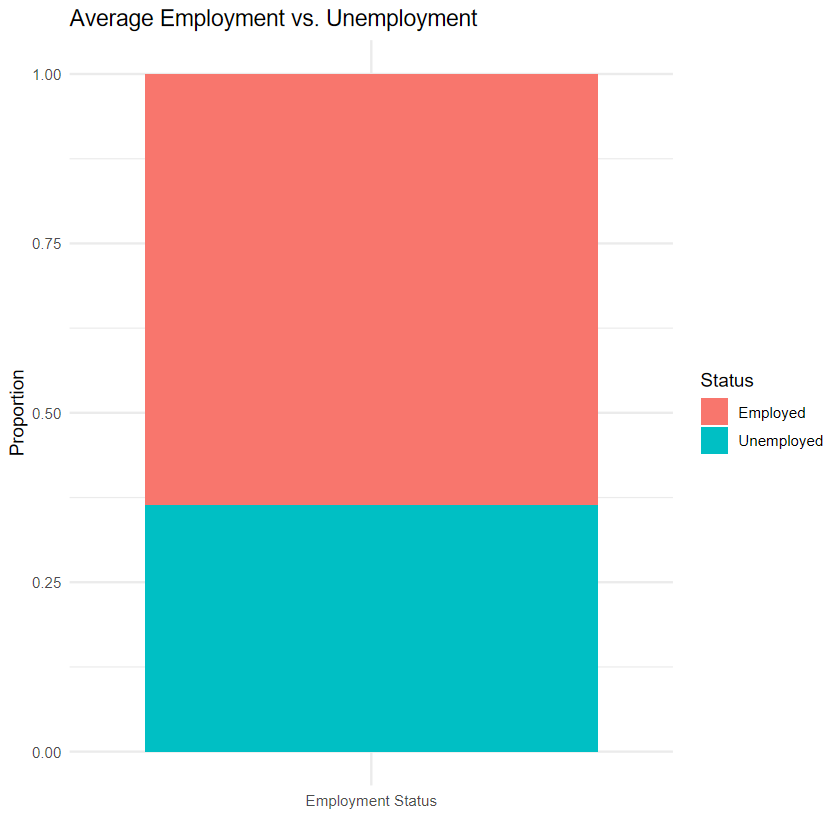

In [155]:
library(ggplot2)
library(dplyr)
library(tidyr)


# Calculate averages
avg_df <- student_debt_data %>%
  summarise(
    Employed = mean(employement_total_employed, na.rm = TRUE),
    Unemployed = mean(employment_total_unemployed, na.rm = TRUE)
  ) %>%
  pivot_longer(everything(), names_to = "Status", values_to = "Average")

# Plot stacked bar chart
ggplot(avg_df, aes(x = "Employment Status", y = Average, fill = Status)) +
  geom_bar(stat = "identity") +
  labs(
    x = "",
    y = "Proportion",
    title = "Average Employment vs. Unemployment"
  ) +
  theme_minimal()


## Data Prep for models

In [44]:
train_idx <- sample(seq_len(nrow(student_debt_data)), size = floor(0.8 * nrow(borrower_data)))
train_data <- student_debt_data[train_idx, ]
test_data <- student_debt_data[-train_idx, ]
# Prep train data
train_data <- train_data %>%
  mutate(minority_share = 1 - race_white) %>%
  select(-starts_with("race_")) %>%
  select(-state, -year, -population_18_or_over_female, -employment_total_unemployed)
# Prepare test data
test_data <- test_data %>%
  mutate(minority_share = 1 - race_white) %>%
  select(-starts_with("race_")) %>%
  select(-state, -year, -population_18_or_over_female, -employment_total_unemployed)

## Function to add model to list of models for GOF Testing Table 

In [323]:
add_model <- function(lst, model) {
  name <- deparse(substitute(model))
  # Clean up any excess parentheses, etc.
  name <- gsub("[\\(\\)]", "", name)
  lst[[name]] <- model
  lst
}

### Code to Populate GOF Testing Table - Prioritizing RMSE and Assumption Testing. 

In [331]:
universal_gof_table <- function(model_list, model_names = NULL) {
  if (!requireNamespace("tibble", quietly = TRUE)) install.packages("tibble")
  if (!requireNamespace("dplyr", quietly = TRUE)) install.packages("dplyr")
  if (!requireNamespace("broom", quietly = TRUE)) install.packages("broom")
  if (!requireNamespace("car", quietly = TRUE)) install.packages("car")
  if (!requireNamespace("lmtest", quietly = TRUE)) install.packages("lmtest")
  if (!requireNamespace("nortest", quietly = TRUE)) install.packages("nortest")
  if (!requireNamespace("glmnet", quietly = TRUE)) install.packages("glmnet")
  library(tibble); library(dplyr); library(broom)
  library(car); library(lmtest); library(nortest); library(glmnet)
  
  glmnet_gof <- function(m, x, y, cv = FALSE) {
    if (cv) {
      lambda <- m$lambda.min
      pred <- predict(m, newx = x, s = "lambda.min")
      mse <- mean((y - pred)^2)
      rmse <- sqrt(mse)
      r2 <- 1 - sum((y - pred)^2) / sum((y - mean(y))^2)
      dev_ratio <- m$glmnet.fit$dev.ratio[which(m$glmnet.fit$lambda == lambda)]
      n_nonzero <- sum(coef(m, s = "lambda.min") != 0)
    } else {
      idx <- which.max(m$dev.ratio)
      lambda <- m$lambda[idx]
      pred <- predict(m, newx = x, s = lambda)
      mse <- mean((y - pred)^2)
      rmse <- sqrt(mse)
      r2 <- 1 - sum((y - pred)^2) / sum((y - mean(y))^2)
      dev_ratio <- m$dev.ratio[idx]
      n_nonzero <- sum(coef(m, s = lambda) != 0)
    }
    tibble(
      RMSE = as.numeric(rmse),
      R2 = as.numeric(r2),
      Adj_R2 = NA,
      Dev_Explained = dev_ratio,
      F = NA,
      F_pval = NA,
      AIC = NA,
      BIC = NA,
      BP_pval = NA,
      DW = NA,
      DW_pval = NA,
      Shapiro_pval = NA,
      Max_VIF = NA,
      N_Influential = NA,
      Lambda = lambda,
      N_Nonzero = n_nonzero
    )
  }
  
  if (is.null(model_names)) {
    nms <- names(model_list)
    if (is.null(nms) || any(nms == "")) {
      model_names <- paste0("Model_", seq_along(model_list))
    } else {
      model_names <- nms
    }
  }
  stopifnot(length(model_names) == length(model_list))
  
  res_list <- lapply(seq_along(model_list), function(i) {
    m <- model_list[[i]]
    this_name <- model_names[i]
    x <- attr(m, "x_data")
    y <- attr(m, "y_data")
    if (inherits(m, "lm") || (inherits(m, "glm") && m$family$family == "gaussian")) {
      m_sum <- summary(m)
      n <- tryCatch(nobs(m), error = function(e) length(resid(m)))
      k <- length(coef(m))
      preds <- predict(m)
      y_true <- m$model[[1]]
      rmse <- sqrt(mean((y_true - preds)^2))
      r2 <- if (!is.atomic(m_sum) && !is.null(m_sum$r.squared)) m_sum$r.squared else NA
      adjr2 <- if (!is.atomic(m_sum) && !is.null(m_sum$adj.r.squared)) m_sum$adj.r.squared else NA
      fstat <- tryCatch(unname(m_sum$fstatistic[1]), error = function(e) NA)
      f_pval <- tryCatch(pf(fstat, m_sum$fstatistic[2], m_sum$fstatistic[3], lower.tail = FALSE), error = function(e) NA)
      aic <- tryCatch(AIC(m), error = function(e) NA)
      bic <- tryCatch(BIC(m), error = function(e) NA)
      bp <- tryCatch(lmtest::bptest(m), error = function(e) NA)
      bp_pval <- if (is.list(bp)) bp$p.value else NA
      dw <- tryCatch(lmtest::dwtest(m), error = function(e) NA)
      dw_stat <- if (is.list(dw)) dw$statistic else NA
      dw_pval <- if (is.list(dw)) dw$p.value else NA
      rlen <- min(length(resid(m)), 5000)
      shapiro <- tryCatch(shapiro.test(sample(resid(m), rlen)), error = function(e) NA)
      shapiro_pval <- if (is.list(shapiro)) shapiro$p.value else NA
      vif_vals <- tryCatch(car::vif(m), error = function(e) NA)
      max_vif <- if (is.numeric(vif_vals)) max(vif_vals, na.rm = TRUE) else NA
      infl <- tryCatch(broom::augment(m), error = function(e) NA)
      n_infl <- if (is.data.frame(infl)) {
        sum(abs(infl$.std.resid) > 3 | infl$.cooksd > 4/n | infl$.hat > 2*k/n, na.rm = TRUE)
      } else NA
      out <- tibble(
        RMSE = rmse,
        R2 = r2,
        Adj_R2 = adjr2,
        Dev_Explained = NA,
        F = fstat,
        F_pval = f_pval,
        AIC = aic,
        BIC = bic,
        BP_pval = bp_pval,
        DW = dw_stat,
        DW_pval = dw_pval,
        Shapiro_pval = shapiro_pval,
        Max_VIF = max_vif,
        N_Influential = n_infl,
        Lambda = NA,
        N_Nonzero = NA
      )
    } else if (inherits(m, "cv.glmnet")) {
      if (!is.null(x) && !is.null(y)) {
        out <- glmnet_gof(m, x, y, cv = TRUE)
      } else {
        out <- tibble(RMSE = NA, R2 = NA, Adj_R2 = NA, Dev_Explained = NA,
                      F = NA, F_pval = NA, AIC = NA, BIC = NA, BP_pval = NA,
                      DW = NA, DW_pval = NA, Shapiro_pval = NA, Max_VIF = NA,
                      N_Influential = NA, Lambda = NA, N_Nonzero = NA)
      }
    } else if (inherits(m, "glmnet")) {
      if (!is.null(x) && !is.null(y)) {
        out <- glmnet_gof(m, x, y, cv = FALSE)
      } else {
        out <- tibble(RMSE = NA, R2 = NA, Adj_R2 = NA, Dev_Explained = NA,
                      F = NA, F_pval = NA, AIC = NA, BIC = NA, BP_pval = NA,
                      DW = NA, DW_pval = NA, Shapiro_pval = NA, Max_VIF = NA,
                      N_Influential = NA, Lambda = NA, N_Nonzero = NA)
      }
    } else {
      out <- tibble(RMSE = NA, R2 = NA, Adj_R2 = NA, Dev_Explained = NA,
                    F = NA, F_pval = NA, AIC = NA, BIC = NA, BP_pval = NA,
                    DW = NA, DW_pval = NA, Shapiro_pval = NA, Max_VIF = NA,
                    N_Influential = NA, Lambda = NA, N_Nonzero = NA)
    }
    out$Model <- this_name
    out
  })
  
  res <- dplyr::bind_rows(res_list) %>% dplyr::select(
    Model,
    RMSE,
    R2,
    Adj_R2,
    Dev_Explained,
    F,
    F_pval,
    AIC,
    BIC,
    BP_pval,
    DW,
    DW_pval,
    Shapiro_pval,
    Max_VIF,
    N_Influential,
    Lambda,
    N_Nonzero
  )
  
  # Round all numeric columns (except Model)
  res[] <- lapply(res, function(x) if (is.numeric(x)) round(x, 3) else x)
  
  # Rename columns for explanation, assumption, and threshold
  colnames(res) <- c(
    "Model",
    "RMSE (Fit: Lower Better)",
    "R2 (Linearity: Higher Better, >0.6 Good)",
    "Adj_R2 (Linearity: Higher Better)",
    "Dev_Explained (Linearity, glmnet: Higher Better)",
    "F (Linearity)",
    "F_pval (Significance: <0.05 Good)",
    "AIC (Model Selection: Lower Better)",
    "BIC (Model Selection: Lower Better)",
    "BP_pval (Homoscedasticity: >0.05 Good)",
    "DW (Independence: 1.5–2.5 Good)",
    "DW_pval (Independence: >0.05 Good)",
    "Shapiro_pval (Normality: >0.05 Good)",
    "Max_VIF (Collinearity: <5 Good)",
    "N_Influential (Influence: Low is Better)",
    "Lambda (glmnet)",
    "N_Nonzero (glmnet: Lower = Simpler)"
  )
  return(res)
}


## Full MLR Model

In [334]:
set.seed(123)
mlr_model <- lm(total_balance_billions ~ ., data = train_data)
summary(mlr_model)

model_list <- add_model(model_list, mlr_model)


Call:
lm(formula = total_balance_billions ~ ., data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.637 -10.313   0.322   9.809  35.530 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       -9.030e+02  1.466e+02  -6.158 4.72e-09 ***
race_two_or_more                   5.107e+02  1.503e+02   3.398 0.000837 ***
race_white                         2.588e+02  1.284e+02   2.015 0.045436 *  
race_black                         2.527e+02  1.316e+02   1.921 0.056379 .  
race_native                        2.161e+02  1.560e+02   1.385 0.167801    
race_asian                         9.080e+02  2.061e+02   4.406 1.81e-05 ***
race_pacific_islander             -4.396e+03  8.018e+02  -5.483 1.41e-07 ***
hispanic_or_latino                 5.289e+01  3.389e+01   1.561 0.120372    
population_18_or_over_male         1.096e+03  2.743e+02   3.997 9.37e-05 ***
employement_total_employed         3.395e+01  6.843e+0

## Log-Transformed MLR Model

In [337]:
set.seed(123)
mlr_model_transformed <- lm(log(total_balance_billions) ~ ., data = train_data)
summary(mlr_model_transformed)
model_list <- add_model(model_list, mlr_model_transformed)



Call:
lm(formula = log(total_balance_billions) ~ ., data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.57464 -0.25413  0.02238  0.30795  0.95278 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       -2.010e+01  4.948e+00  -4.062 7.28e-05 ***
race_two_or_more                   2.235e+01  5.072e+00   4.407 1.81e-05 ***
race_white                         1.248e+01  4.334e+00   2.879  0.00447 ** 
race_black                         1.329e+01  4.439e+00   2.993  0.00316 ** 
race_native                        2.071e+00  5.265e+00   0.393  0.69449    
race_asian                         3.406e+01  6.954e+00   4.898 2.15e-06 ***
race_pacific_islander             -7.296e+01  2.705e+01  -2.697  0.00767 ** 
hispanic_or_latino                 1.546e+00  1.143e+00   1.352  0.17794    
population_18_or_over_male         1.116e+01  9.255e+00   1.206  0.22951    
employement_total_employed        -3.00

## Clustered Model

In [340]:
state_features_for_clustering <- student_debt_data %>%
  group_by(state) %>%
  summarise(
    across(
      .cols = -c(year),
      .fns = mean,
      na.rm = TRUE
    ),
    .groups = "drop"
  )

state_features_for_clustering_clean <- na.omit(state_features_for_clustering)

state_names_for_clustering <- state_features_for_clustering_clean$state

numeric_state_features <- state_features_for_clustering_clean %>%
  select(where(is.numeric))

scaled_state_features <- scale(numeric_state_features)

kmeans_result <- kmeans(scaled_state_features, centers = 5, nstart = 25)

state_cluster_map <- data.frame(
  state = state_names_for_clustering,
  state_cluster = as.factor(kmeans_result$cluster)
)

combined_data_with_clusters <- student_debt_data %>%
  left_join(state_cluster_map, by = "state")

 train_idx <- sample(seq_len(nrow(combined_data_with_clusters)), size = floor(0.8 * nrow(combined_data_with_clusters)))
train_data_cluster <- combined_data_with_clusters[train_idx, ]
test_data_cluster <- combined_data_with_clusters[-train_idx, ]

train_data <- train_data_cluster %>%
  select(-state, -year, -race_other, -population_18_or_over_female, -employment_total_unemployed)

mlr_model_cluster <- lm(total_balance_billions ~ ., data = train_data)
summary(mlr_model_cluster)
model_list <- add_model(model_list, mlr_model_transformed)




Call:
lm(formula = total_balance_billions ~ ., data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.637 -10.313   0.322   9.809  35.530 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       -9.030e+02  1.466e+02  -6.158 4.72e-09 ***
race_two_or_more                   5.107e+02  1.503e+02   3.398 0.000837 ***
race_white                         2.588e+02  1.284e+02   2.015 0.045436 *  
race_black                         2.527e+02  1.316e+02   1.921 0.056379 .  
race_native                        2.161e+02  1.560e+02   1.385 0.167801    
race_asian                         9.080e+02  2.061e+02   4.406 1.81e-05 ***
race_pacific_islander             -4.396e+03  8.018e+02  -5.483 1.41e-07 ***
hispanic_or_latino                 5.289e+01  3.389e+01   1.561 0.120372    
population_18_or_over_male         1.096e+03  2.743e+02   3.997 9.37e-05 ***
employement_total_employed         3.395e+01  6.843e+0

## Transformed Clustered Model

## Elastic Net Model

In [344]:
all_var <- model.matrix(total_balance_billions ~ . -1, data = train_data) 
elastic_net_model_cv <- glmnet::cv.glmnet(all_var, train_data$total_balance_billions, family='gaussian', alpha=0.5, nfolds=10)
elastic_net_model <- glmnet::glmnet(all_var, train_data$total_balance_billions, family='gaussian', alpha=1, nlambda=100)
round(elastic_net_model_cv$lambda.min,4)
summary(elastic_net_model)
model_list <- add_model(model_list, elastic_net_model)


######### FOR GLMENT - WE MUST ATTACH THE predictors & response FOR GOF TESTING TABLE

attr(elastic_net_model_cv, "x_data") <- all_var
attr(elastic_net_model_cv, "y_data") <- train_data$total_balance_billions

attr(elastic_net_model, "x_data") <- all_var
attr(elastic_net_model, "y_data") <- train_data$total_balance_billions

# Add to model list (or use your own model_list object)

model_list <- add_model(model_list, elastic_net_model)
model_list <- add_model(model_list, elastic_net_model_cv)



[1] 0.0047

          Length Class     Mode   
a0          92   -none-    numeric
beta      1932   dgCMatrix S4     
df          92   -none-    numeric
dim          2   -none-    numeric
lambda      92   -none-    numeric
dev.ratio   92   -none-    numeric
nulldev      1   -none-    numeric
npasses      1   -none-    numeric
jerr         1   -none-    numeric
offset       1   -none-    logical
call         6   -none-    call   
nobs         1   -none-    numeric

In [346]:
# Scratch work - MLR
set.seed(123)

student_debt_data <- read.csv("../data/combined_clean_data.csv")

train_idx <- sample(seq_len(nrow(student_debt_data)), size = floor(0.8 * nrow(borrower_data)))
train_data <- student_debt_data[train_idx, ]
test_data <- student_debt_data[-train_idx, ]
# Prep train data
train_data <- train_data %>%
  mutate(minority_share = 1 - race_white) %>%
  select(-starts_with("race_")) %>%
  select(-state, -year, -population_18_or_over_female, -employment_total_unemployed)
# Prepare test data
test_data <- test_data %>%
  mutate(minority_share = 1 - race_white) %>%
  select(-starts_with("race_")) %>%
  select(-state, -year, -population_18_or_over_female, -employment_total_unemployed)
colnames(test_data)
colnames(train_data)
#mlr_model <- lm(total_balance_billions ~ . -year, data = train_data)
mlr_model <- lm(total_balance_billions ~ ., data = train_data)

summary(mlr_model)
vif(mlr_model)

[1] "hispanic_or_latino"                "population_18_or_over_male"       
 [3] "employement_total_employed"        "mean_household_income_dollars"    
 [5] "total_population_bachelors_degree" "total_veteran"                    
 [7] "total_foreign_born_pop"            "total_household_w_internet"       
 [9] "average_household_size"            "total_borrowers"                  
[11] "total_balance_billions"            "minority_share"

[1] "hispanic_or_latino"                "population_18_or_over_male"       
 [3] "employement_total_employed"        "mean_household_income_dollars"    
 [5] "total_population_bachelors_degree" "total_veteran"                    
 [7] "total_foreign_born_pop"            "total_household_w_internet"       
 [9] "average_household_size"            "total_borrowers"                  
[11] "total_balance_billions"            "minority_share"


Call:
lm(formula = total_balance_billions ~ ., data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-53.569 -13.607  -1.184  10.648  69.146 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       -1.477e+02  1.092e+02  -1.352 0.177735    
hispanic_or_latino                 3.823e+00  2.036e+01   0.188 0.851224    
population_18_or_over_male         1.750e+02  2.607e+02   0.671 0.502828    
employement_total_employed        -1.713e+02  7.755e+01  -2.208 0.028319 *  
mean_household_income_dollars     -1.253e-03  1.760e-04  -7.117 1.75e-11 ***
total_population_bachelors_degree  2.458e+01  5.544e+01   0.443 0.658001    
total_veteran                     -5.715e+02  1.258e+02  -4.542 9.44e-06 ***
total_foreign_born_pop             3.908e+02  4.760e+01   8.209 2.32e-14 ***
total_household_w_internet         2.299e+02  5.929e+01   3.878 0.000141 ***
average_household_size             1.462e+01  1.170e+0

hispanic_or_latino        population_18_or_over_male 
                         2.436188                          4.356888 
       employement_total_employed     mean_household_income_dollars 
                         3.909949                          4.037348 
total_population_bachelors_degree                     total_veteran 
                         4.441363                          2.041249 
           total_foreign_born_pop        total_household_w_internet 
                         4.594095                          2.872773 
           average_household_size                   total_borrowers 
                         1.454985                          2.739081 
                   minority_share 
                         2.248205

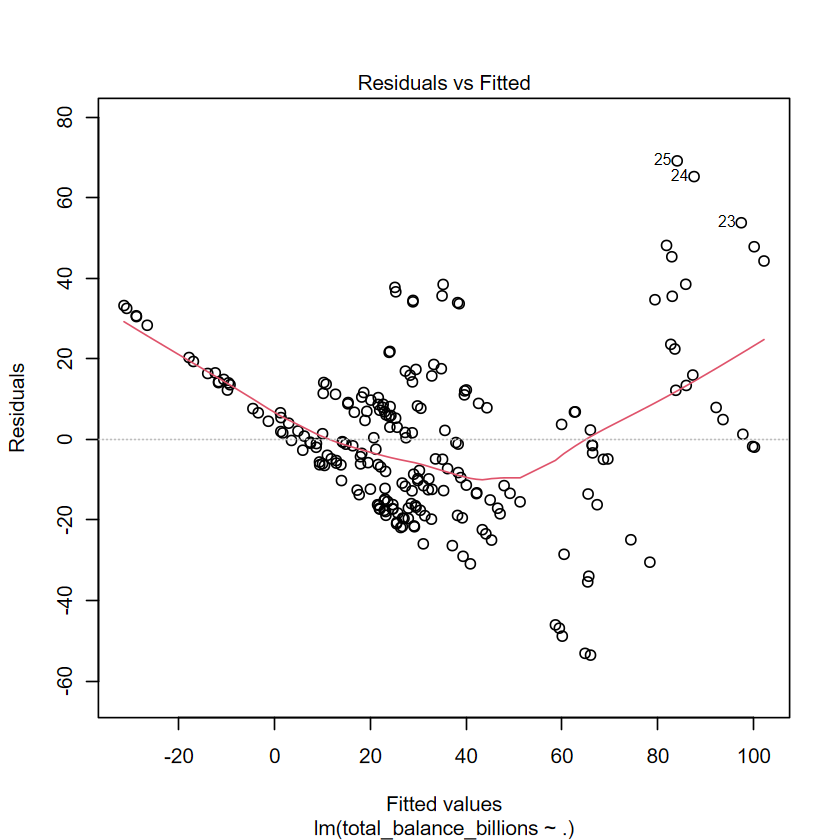

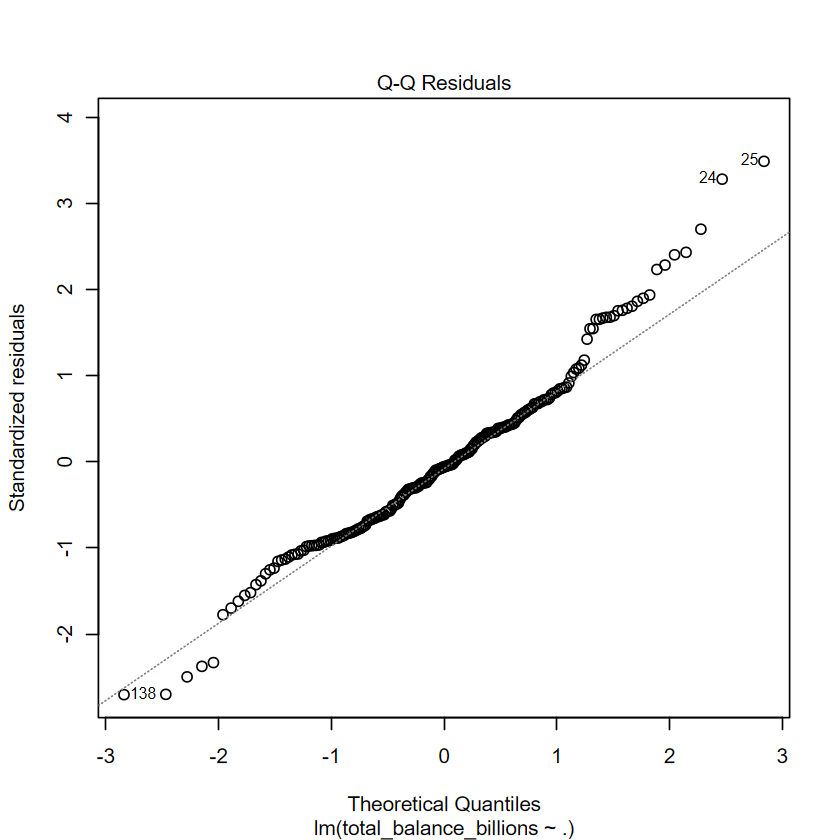

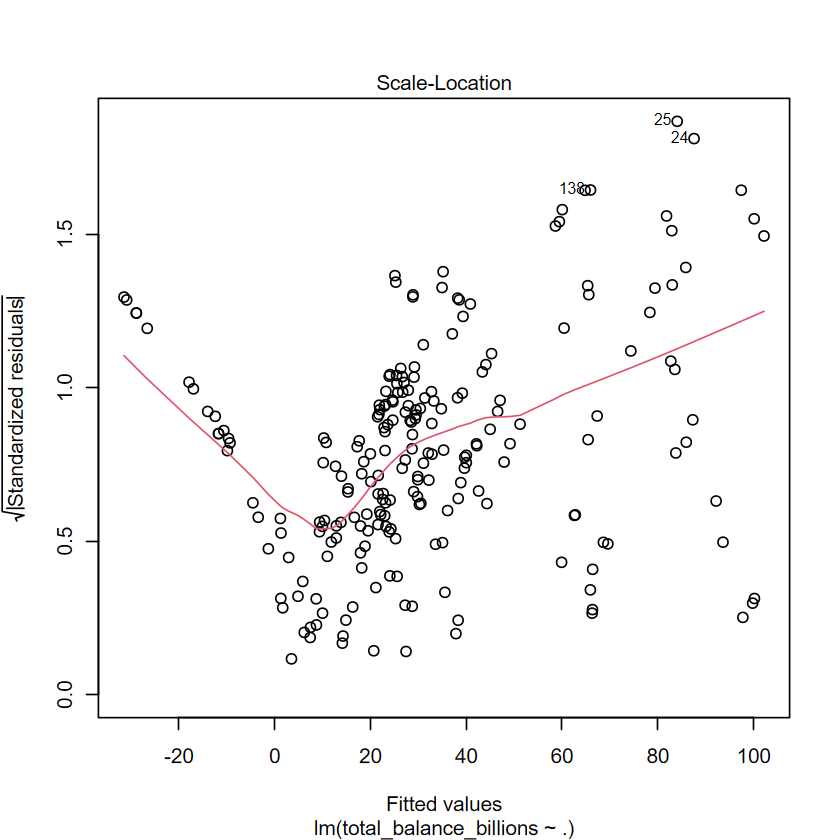

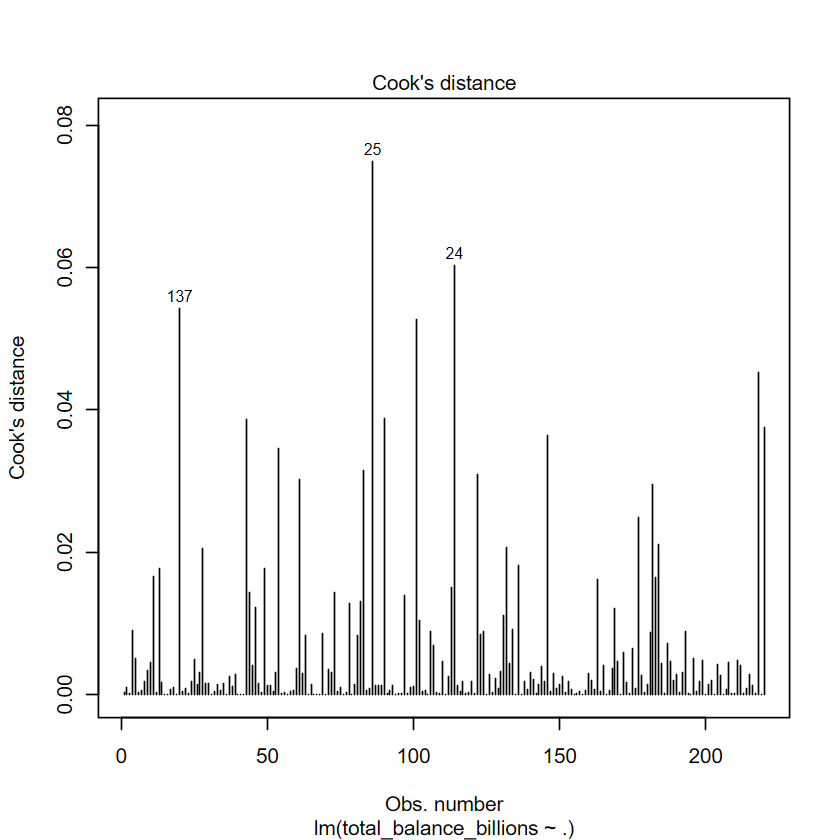

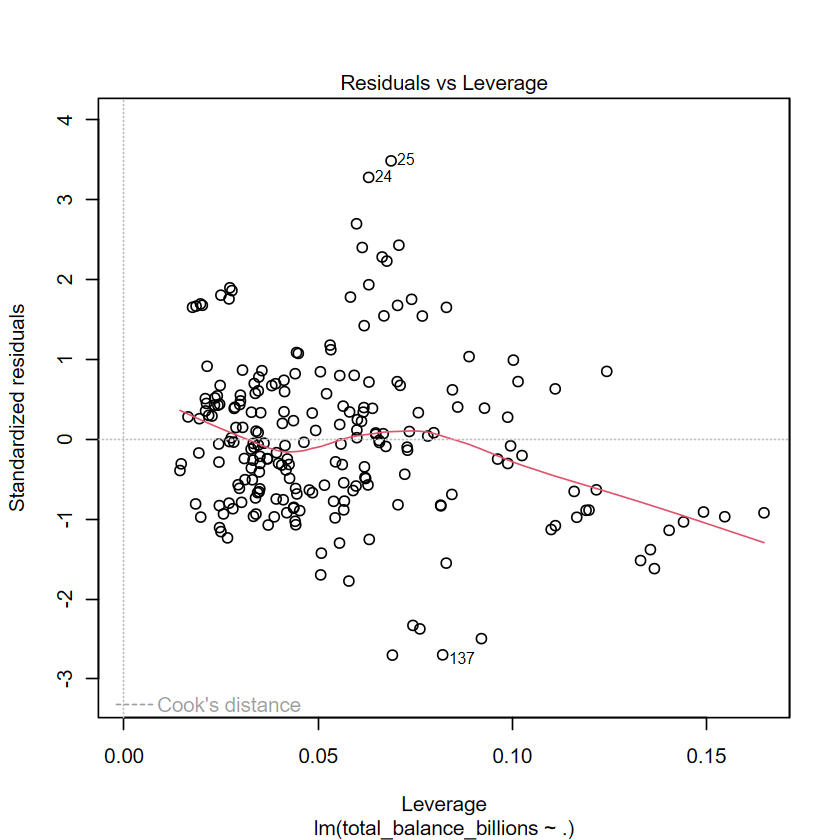

In [348]:
plot(mlr_model, which = 1)
plot(mlr_model, which = 2)
plot(mlr_model, which = 3)
plot(mlr_model, which = 4)
plot(mlr_model, which = 5)

In [350]:
mlr_model_transformed <- lm(log(total_balance_billions) ~ ., data = train_data)
summary(mlr_model_transformed)


Call:
lm(formula = log(total_balance_billions) ~ ., data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.50590 -0.43261  0.02354  0.40901  1.14826 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        4.655e+00  3.042e+00   1.530   0.1274    
hispanic_or_latino                -4.288e-01  5.672e-01  -0.756   0.4505    
population_18_or_over_male        -1.586e+01  7.264e+00  -2.184   0.0301 *  
employement_total_employed        -5.795e+00  2.161e+00  -2.682   0.0079 ** 
mean_household_income_dollars     -5.494e-05  4.904e-06 -11.203  < 2e-16 ***
total_population_bachelors_degree  3.271e+00  1.545e+00   2.118   0.0354 *  
total_veteran                     -2.049e+01  3.505e+00  -5.845 1.94e-08 ***
total_foreign_born_pop             9.526e+00  1.326e+00   7.183 1.19e-11 ***
total_household_w_internet         1.173e+01  1.652e+00   7.104 1.89e-11 ***
average_household_size             3.18

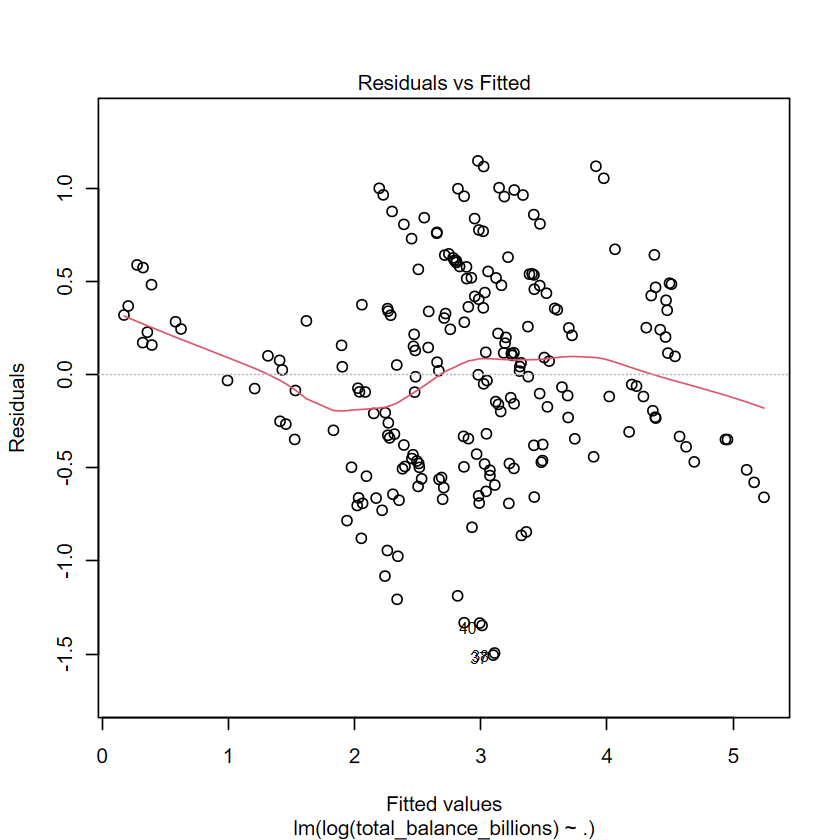

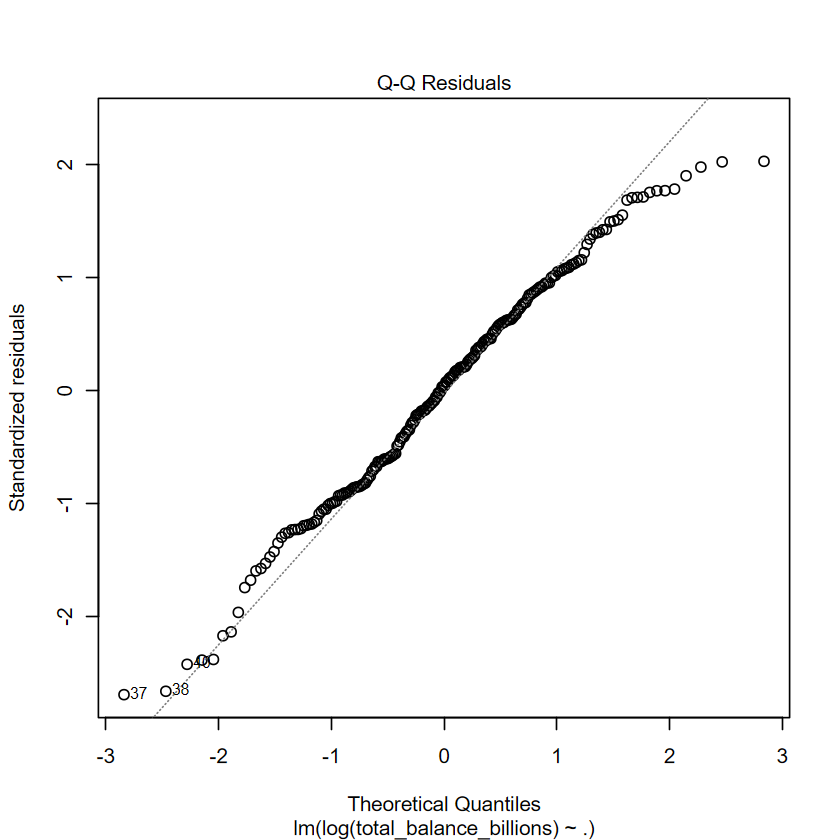

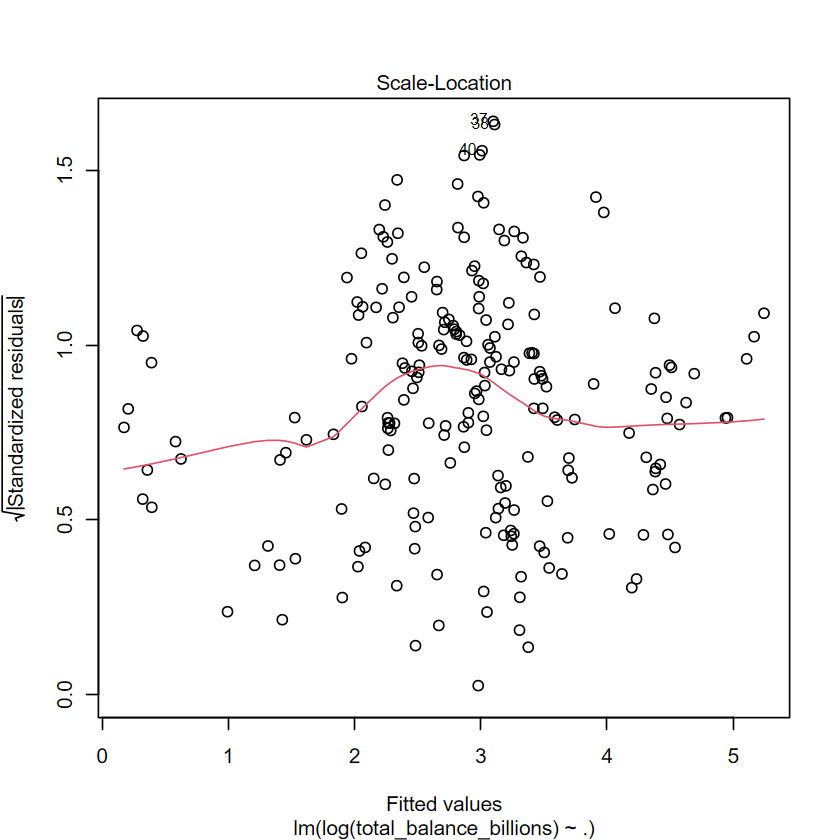

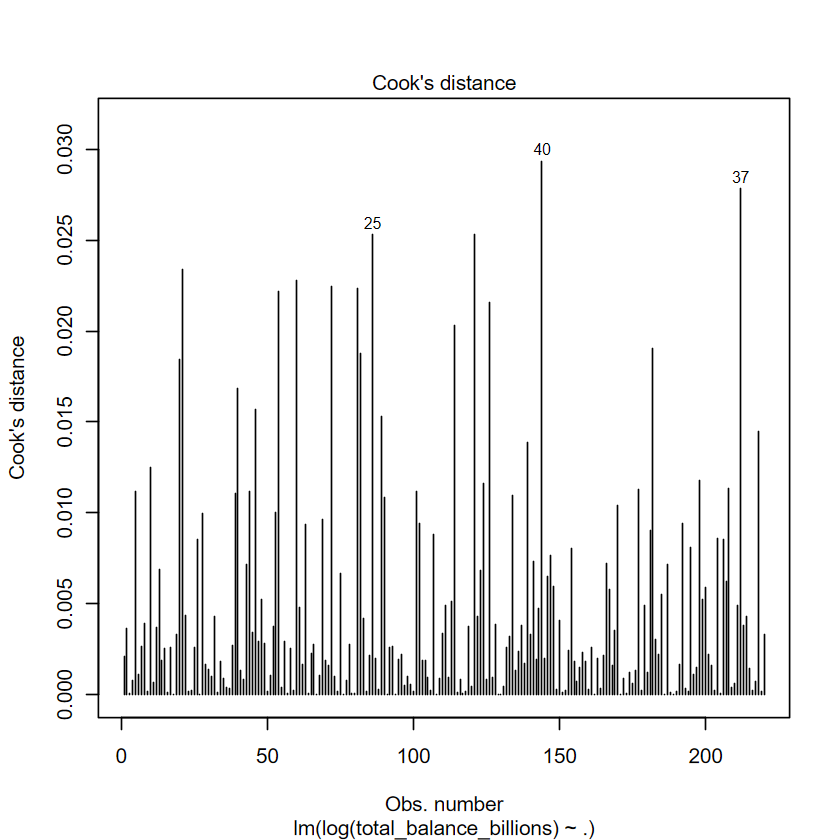

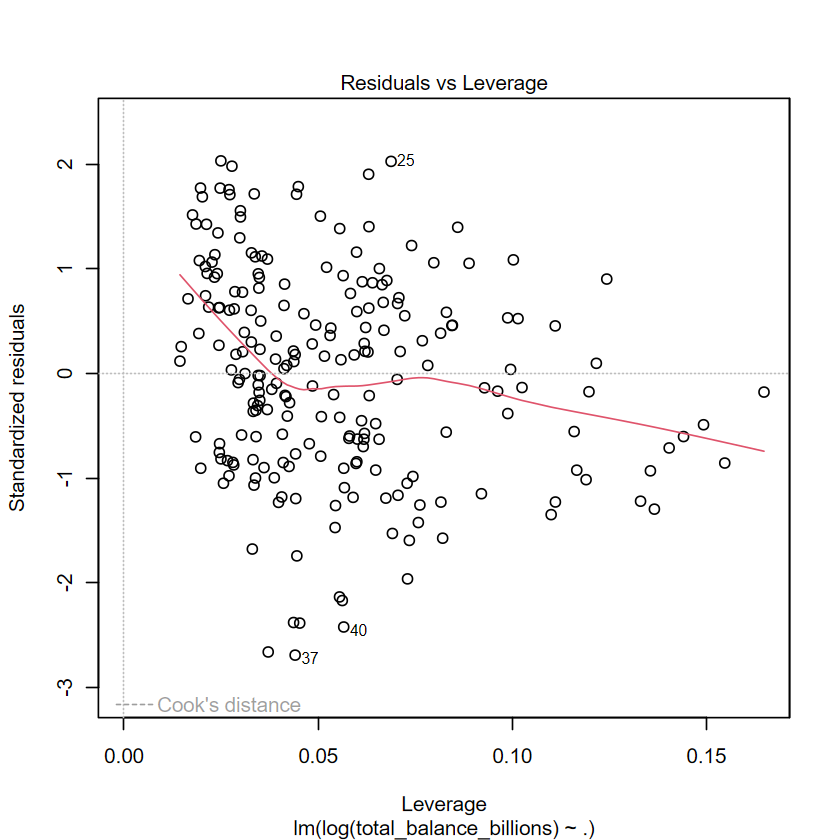

In [352]:
plot(mlr_model_transformed, which = 1)
plot(mlr_model_transformed, which = 2)
plot(mlr_model_transformed, which = 3)
plot(mlr_model_transformed, which = 4)
plot(mlr_model_transformed, which = 5)

In [355]:
uni_gof_table <- universal_gof_table(model_list)
uni_gof_table

Model,RMSE (Fit: Lower Better),"R2 (Linearity: Higher Better, >0.6 Good)",Adj_R2 (Linearity: Higher Better),"Dev_Explained (Linearity, glmnet: Higher Better)",F (Linearity),F_pval (Significance: <0.05 Good),AIC (Model Selection: Lower Better),BIC (Model Selection: Lower Better),BP_pval (Homoscedasticity: >0.05 Good),DW (Independence: 1.5–2.5 Good),DW_pval (Independence: >0.05 Good),Shapiro_pval (Normality: >0.05 Good),Max_VIF (Collinearity: <5 Good),N_Influential (Influence: Low is Better),Lambda (glmnet),N_Nonzero (glmnet: Lower = Simpler)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mlr_model,13.333,0.841,0.823,NA,47.183,0,1647.664,1720.227,0,1.964,0.389,0.036,12545.58,20,NA,NA
mlr_model_transformed,0.450,0.834,0.815,NA,44.875,0,292.070,364.633,0,2.200,0.919,0.000,12545.58,24,NA,NA
elastic_net_model,13.339,0.840,NA,0.84,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.004,22
elastic_net_model_cv,13.339,0.840,NA,0.84,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.005,22


## Predictions

# Step 0. Data Cleaning (Done)
- Read demographics and social characteristics data from the US census website
- Read the student loan and borrowed data from NY Fed Bank website
- Clean and model the data (standardize each data per state)
- Create train and test sets
# Step 1. Models to explore
- MLR Model (Done)
- Transformed MLR Model (Done)
- Clustered model (Done)
- Transformed clustered model
- Elastic Net: Variable selection

# Step 2. Goodness of fit tests/Model Assumptions
- Linearity
- Constant Variance
- Independence
- Normality

# Step 3. Prediction
- MLR
- Transformed
- Clustered
- Transformed clustered
- Elastic Net
- Look at the 5 models and actual value
- Predict with a threshold of 0.3
- Confusion matrix with specificity and sensitivity

# Step 4. Interpret
- Interpret the best model and explain why we chose the model and pitfalls of the model